## EM算法和GMM模型
参考：
+ [如何感性地理解EM算法--简书](http://www.jianshu.com/p/1121509ac1dc)
+ [GMM](http://blog.sina.com.cn/s/blog_54d460e40101ec00.html)
+ [EM](http://www.cnblogs.com/jerrylead/archive/2011/04/06/2006936.html)


### 1. 生成数据

类别概率： [ 0.37055675  0.2182919   0.41115134]
样本数目： [56 33 61]


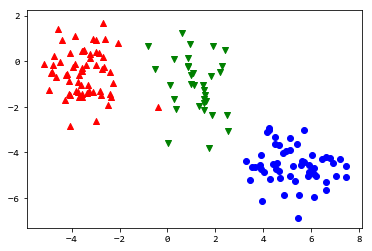

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as plt_markers
import matplotlib.colors as plt_colors

# 类别数,均值,标准差，生成样本数目
class_num = 3
dim = 2
means = np.random.uniform(low=-10,high=10,size=(class_num,dim))
cov = np.eye(N=dim) #都使用eye(1)作为协方差
sample_num_all = 50*class_num

# 生成每个类别的概率和样本数目
class_weights = np.random.random(size=class_num)
class_weights = class_weights/class_weights.sum()
sample_nums = np.around(sample_num_all*class_weights).astype(np.int)
sample_nums[-1] = sample_num_all - sample_nums[:-1].sum()
print("类别概率：",class_weights)
print("样本数目：",sample_nums)

# 画图的marker和color
markers_used = plt_markers.MarkerStyle.filled_markers
colors_used = list(plt_colors.cnames.keys())
colors_used = "bgrcmykw"

# 生成样本
sample_all = []
for i in range(class_num):
    sample_temp = \
        np.random.multivariate_normal(means[i],cov,size=sample_nums[i])
    sample_all.append(sample_temp)
    plt.scatter(x=sample_temp[:,0],y=sample_temp[:,1],
                c=colors_used[i],marker=markers_used[i])
plt.show()
sample_all = np.concatenate(sample_all)

### 2. 迭代求解
均值：$\mu_k = \frac{1}{\sum_i w(i,k)}\sum_i w(i,k)\cdot x_i$

协方差矩阵：$\Sigma_k = \frac{1}{\sum_i w(i,k)} \sum_i w(i,k)\cdot (x_i - \mu_k)^T\cdot(x_i-\mu_k)$

分布权重：$\pi_k = \frac{\sum_i w(i,k)}{N}$

In [78]:
# 初始化参数
pi_predict = np.random.random(size=class_num)
pi_predict = pi_predict/pi_predict.sum()

means_predict = np.random.random(size=(class_num,dim))
print("means：",means_predict)

# 生成半正定的协方差矩阵
# cov_predict = np.random.random(size=(dim,dim))  
# cov_predict = cov_predict.T.dot(cov_predict)
# 使用纯对角线的方式生成
cov_predict = np.eye(N=dim)*np.random.random(size=1)
print("cov：",cov_predict)

means： [[ 0.67151888  0.07388553]
 [ 0.02040605  0.04160324]
 [ 0.22785854  0.0189937 ]]
cov： [[ 0.14304788  0.        ]
 [ 0.          0.14304788]]


In [86]:
import scipy.stats
# E步: 计算每个类的条件概率
w_ik = []
for k in range(class_num):
    w_k = scipy.stats.multivariate_normal.pdf(mean=means_predict[k],cov=cov_predict,
                                              x=sample_all)
    w_ik.append(w_k.reshape(sample_num_all,1))
w_ik = np.concatenate(w_ik,axis=1)
w_ik = w_ik/w_ik.sum(axis=1,keepdims=True)

#M步：估计参数

# 估计均值
# sample_all: sample*dim -> sample*1*dim
# w_ik: sample*k -> sample*k*1
means_predict = (sample_all[:,np.newaxis]*w_ik[:,:,np.newaxis]).sum(axis=0) \
                        /(w_ik.sum(axis=0)[:,np.newaxis])

# 估计协方差矩阵
# x_sub_mean: 1*sample*dim - k*1*dim = k*sample*dim
x_sub_mean = sample_all[np.newaxis,:,:]-means_predict[:,np.newaxis,:]
# w_ik.T[:,:,np.newaxis]*x_sub_mean: k*sample*1 * k*sample*dim =  k*sample*dim
# cov_predict: k*dim*sample (matmul) k*sample*dim = k*dim*dim
cov_predict = np.matmul(x_sub_mean.transpose(0,2,1), w_ik.T[:,:,np.newaxis]*x_sub_mean) \
                        /(w_ik.sum(axis=0)[:,np.newaxis,np.newaxis])
cov_predict = cov_predict.mean(axis=0)

# 估计权重
pi_predict = w_ik.sum(axis=0)/sample_num_all

print("means: ",means_predict)
print("Pi：",pi_predict)
print("Cov：",cov_predict)

means:  [[ 5.27999436 -4.57248317]
 [-3.54728283 -0.49046016]
 [ 1.15010282 -1.07414564]]
Pi： [ 0.37398129  0.40085977  0.22515894]
Cov： [[ 0.83812781 -0.10288788]
 [-0.10288788  1.01628649]]


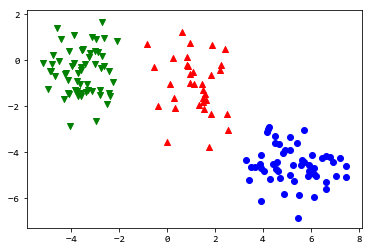

In [87]:
# 画出分类结果
p_ik = []
for k in range(class_num):
    p_k = scipy.stats.multivariate_normal.pdf(mean=means_predict[k],cov=cov_predict,
                                              x=sample_all)
    p_ik.append(p_k.reshape(sample_num_all,1))
p_ik = np.concatenate(p_ik,axis=1)
predict = np.argmax(p_ik,axis=1)
for k in range(class_num):
    index_temp = np.where(predict==k)
    sample_predict_k = sample_all[index_temp]
    plt.scatter(x=sample_predict_k[:,0],y=sample_predict_k[:,1],
                c=colors_used[k],marker=markers_used[k])
plt.show()
    